## Cobra sampling benchmark

This illustrates the new cobra sampling and gives some basic performance metrics.

### Generating samples

In [1]:
%matplotlib inline
from cobra.test import create_test_model
from cobra.flux_analysis.sampling import OptGPSampler, ACHRSampler
import pandas as pd

mod = create_test_model("textbook")      # 95 reactions

All the samplers implement thinning (only using every n samples) to avoid autocorrelation, we will start with versions without thinning to illustrate the basic performance.

In [2]:
achr = ACHRSampler(mod, thinning=1)

In [3]:
optgp = OptGPSampler(mod, processes=1, thinning=1)

In [4]:
achr_samples = achr.sample(1000)
achr_samples = pd.DataFrame(achr_samples, columns=[r.id for r in mod.reactions])

In [5]:
optgp_samples = optgp.sample(1000)
optgp_samples = pd.DataFrame(optgp_samples, columns=[r.id for r in mod.reactions])

We can also validate our samples. Using the validate method of the classes (`v` means valid, see docstring for more info).

In [6]:
from collections import Counter

print(Counter(achr.validate(achr_samples)))
print(Counter(optgp.validate(optgp_samples)))

Counter({'v': 1000})
Counter({'v': 1000})


### Autocorrelation

ACHR should perform a bit better since it does not used delayed updates as optGP...

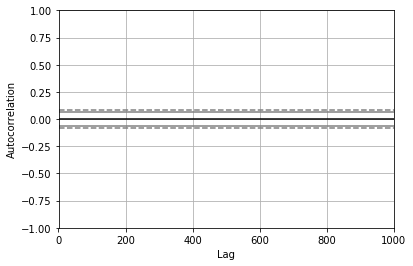

In [7]:
from pandas.plotting import autocorrelation_plot as acp
import matplotlib.pyplot as plt

def normalize(df): return (df - df.mean()) / df.std()
acp(normalize(achr_samples))

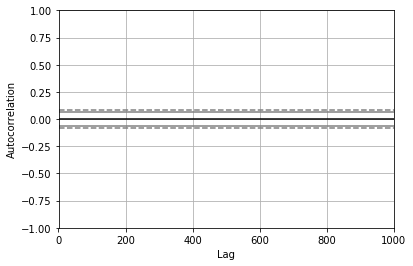

In [8]:
acp(normalize(optgp_samples))

We see that autocorrelation diminishes after 100 iterations, which is why the default thinning factor is 100. Thus, using the default contructors we get:

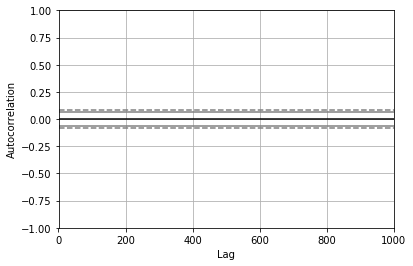

In [9]:
achr = ACHRSampler(mod)
achr_samples = achr.sample(1000)
achr_samples = pd.DataFrame(achr_samples, columns=[r.id for r in mod.reactions])
acp(normalize(achr_samples))

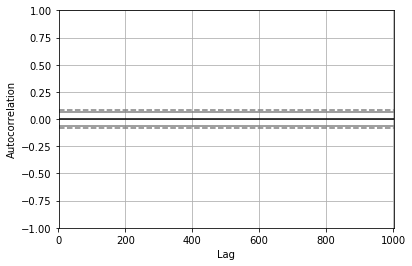

In [10]:
optgp = OptGPSampler(mod, 6)
optgp_samples = optgp.sample(1000)
optgp_samples = pd.DataFrame(optgp_samples, columns=[r.id for r in mod.reactions])
acp(normalize(optgp_samples))

OptGP samples one chain per process. This can be nicely seen in the autocorrelation function where we have a peak for each process. Those do not influence overall convergence since they quickly drop... This can be seen by plotting the trace which shows pretty much uniform sampling. Nevertheless, the preferred use case for OptGP is to sample large chains, meaning sampling many flux distributions for each batch.

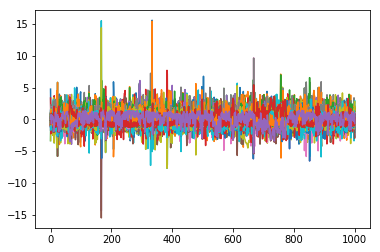

In [11]:
normalize(optgp_samples).plot(legend=False)

## Performance

Sampling itself obviously takes time, however there is also an initializiation overhead since the initial warmup points are generated from a set of 2 * n_r LP problems. 

### Small model

In [12]:
print(mod.id)
print(len(mod.metabolites), len(mod.reactions), sep=", ")

e_coli_core
72, 95


In [13]:
achr = %time ACHRSampler(mod)
t = %timeit -r1 -n1 -o achr.sample(1000)
print("Time per iteration = {:.2f} μs".format(t.worst / achr.thinning / 1000 * 1e6))
print("Time per sample = {:.2f} ms".format(t.worst / 1000 * 1e3))

CPU times: user 248 ms, sys: 410 ms, total: 658 ms
Wall time: 111 ms
7.75 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Time per iteration = 77.52 μs
Time per sample = 7.75 ms


In [14]:
optgp = %time OptGPSampler(mod, 4)
t = %timeit -r1 -n1 -o optgp.sample(1000)
print("Time per iteration = {:.2f} μs".format(t.worst / achr.thinning / 1000 * 1e6))
print("Time per sample = {:.2f} ms".format(t.worst / 1000 * 1e3))

CPU times: user 269 ms, sys: 380 ms, total: 649 ms
Wall time: 104 ms
2.13 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Time per iteration = 21.26 μs
Time per sample = 2.13 ms


This gives a speed up in the order of the number of processes.

### Large model

In [15]:
ecoli = create_test_model("ecoli")

print(ecoli.id)
print(len(ecoli.metabolites), len(ecoli.reactions), sep=", ")

iJO1366
1805, 2583


In [16]:
achr = %time ACHRSampler(ecoli)
t = %timeit -r1 -n1 -o achr.sample(100)
print("Time per iteration = {:.2f} μs".format(t.worst / achr.thinning / 100 * 1e6))
print("Time per sample = {:.2f} ms".format(t.worst / 100 * 1e3))

CPU times: user 1min 52s, sys: 11.4 s, total: 2min 4s
Wall time: 58.9 s
2.51 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Time per iteration = 251.13 μs
Time per sample = 25.11 ms


In [17]:
optgp = %time OptGPSampler(ecoli, 4)
t = %timeit -r1 -n1 -o optgp.sample(100)
print("Time per iteration = {:.2f} μs".format(t.worst / optgp.thinning / 100 * 1e6))
print("Time per sample = {:.2f} ms".format(t.worst / 100 * 1e3))

CPU times: user 2min 1s, sys: 58.4 s, total: 2min 59s
Wall time: 1min 17s
1.03 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Time per iteration = 103.33 μs
Time per sample = 10.33 ms
